In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transformsD
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import json
import pickle

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 32
AVAIL_GPUS = min(1,torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count()/2)
NUM_WORKERS = 1

In [2]:
# os.mkdir("Results")

In [2]:
p = 32

In [3]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, root_dir = "Landscape", transform=None,img_size=(256, 256),wp = 3,hp = 3,split=None):
        super(CustomDataset).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(self.root_dir)
        self.img_size = img_size
        self.wp = wp
        self.hp = hp
        random.seed(random_seed)
        random.shuffle(self.image_files)

        if split is not None:
            train_ratio=0.8
            val_ratio=0.1
            random.shuffle(self.image_files)

            if split=='train':
                self.image_files = self.image_files[:int(len(self.image_files)*train_ratio)]
            elif split=='val':
                self.image_files = self.image_files[int(len(self.image_files) * train_ratio):int(len(self.image_files)*(train_ratio+val_ratio))]
            elif split=='test':
                self.image_files = self.image_files[int(len(self.image_files)*(train_ratio+val_ratio)):]


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB').resize(self.img_size)
        
        mask_size = (p,p)
        x = 128
        y = 128
        mask_box = (x-p//2,y-p//2, x+ p//2,y + p//2)

        

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)
        
        masked_image = image.clone()
        masked_image[:,x-p//2:x+p//2,y-p//2:y + p//2] = torch.zeros(size = (3,p,p))

        return image,masked_image 

transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.23, 0.23, 0.23])
])

train_dataset = CustomDataset(root_dir='Landscape',transform=transform,split='train')
val_dataset = CustomDataset(root_dir='Landscape',transform=transform,split='val')
test_dataset = CustomDataset(root_dir='Landscape',transform=transform,split='test')

train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)


In [4]:
for images,masked_images in train_dataloader:
    break
masked_images.shape

torch.Size([32, 3, 256, 256])

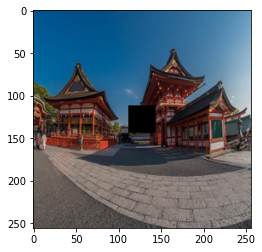

In [5]:
plt.imshow(masked_images[0].permute(1,2,0))

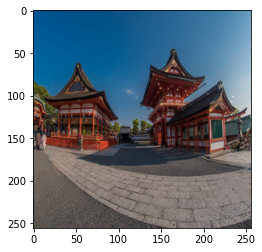

In [6]:
plt.imshow(images[0].permute(1,2,0))

In [7]:
USE_GPU = True
num_class = 12
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder1 = nn.Conv2d(3, 64, 4, 2, 1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.encoder2 = nn.Conv2d(64, 128, 4, 2, 1, bias=True)
        self.bn2 = nn.BatchNorm2d(128)
        self.encoder3 = nn.Conv2d(128, 256, 4, 2, 1, bias=True)
        self.bn3 = nn.BatchNorm2d(256)
        self.encoder4 = nn.Conv2d(256, 3, 3, 1, 1, bias=True)


    def forward(self, input):        
        encoded = F.relu(self.bn1(self.encoder1(input)))
        encoded = F.relu(self.bn2(self.encoder2(encoded)))
        encoded = F.relu(self.bn3(self.encoder3(encoded)))
        encoded = F.sigmoid(self.encoder4(encoded))
        return encoded


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.decoder1 = nn.Conv2d(3, 64, 3, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.decoder2 = nn.Conv2d(64, 128, 3, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.decoder3 = nn.Conv2d(128, 256, 3, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.decoder4 = nn.Conv2d(256, 1, 3, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, input):
        decoded = F.relu(self.bn1(self.decoder1(input)))
        decoded = F.relu(self.bn2(self.decoder2(decoded)))
        decoded = F.relu(self.bn3(self.decoder3(decoded)))
        decoded = self.sigmoid(self.decoder4(decoded))
        
        return decoded


In [14]:
lr = 5e-6
beta1 = 0.5
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


criterion = nn.BCELoss()
reconstruction_loss = nn.MSELoss()
num_epochs = 20
best_generator_loss = 10

train_loss = {}
val_loss = {}

for epoch in range(num_epochs):
    generator.train()
    
    for batch_idx, (real_images, masked_images) in enumerate(train_dataloader):
        dlosses = []
        glosses = []
        grlosses = []
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)

        # Train discriminator
        discriminator.zero_grad()
        generator.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Real images
        real_outputs = discriminator(real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]).reshape(batch_size,1)
        d_loss_real = criterion(real_outputs, real_labels)

        # Fake images
        fake_images = generator(masked_images)
        fake_outputs = discriminator(fake_images.detach()).reshape(batch_size,1)
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train generator
        fake_outputs = discriminator(fake_images).reshape(batch_size,1)
        g_loss = criterion(fake_outputs, real_labels)# + reconstruction_loss(fake_images,real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2])
        g_loss.backward()
        optimizer_g.step()
        gr_loss = reconstruction_loss(fake_images,real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2])
        
        dlosses.append(d_loss.item())
        glosses.append(g_loss.item())
        grlosses.append(gr_loss.item())
        
        
        
        if (batch_idx + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
                  f"Discriminator Loss: {np.mean(dlosses):.4f}, Generator Loss: {np.mean(glosses).item():.4f}")
            train_loss[(epoch+1),(batch_idx+1)] = (np.mean(glosses),np.mean(grlosses))
            
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
        f"Discriminator Loss: {np.mean(dlosses):.4f}, Generator Loss: {np.mean(glosses).item():.4f}")
    train_loss[(epoch+1),(batch_idx+1)] = (np.mean(glosses),np.mean(grlosses))
    
    generator.eval()
    val_glosses = []
    for batch_idx, (real_images, masked_images) in enumerate(val_dataloader):
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)
        
        
        fake_patches = generator(masked_images)
        real_patches = real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]
        g_loss = reconstruction_loss(fake_patches,real_patches)
        
        val_glosses.append(g_loss.item())
    
    mean_g_loss = np.mean(val_glosses)
#     print("mean_generator_val_loss: ",np.mean(mean_g_loss))

    val_loss[epoch+1] = np.mean(mean_g_loss)
    
    if(mean_g_loss < best_generator_loss):
        best_generator_loss = mean_g_loss
        best_generator_dict = generator.state_dict()
        print("best")
        
    print(f"Epoch [{epoch+1}/{num_epochs}],"
        f"Val Generator Loss: {mean_g_loss:.4f}")
    
# torch.save(best_generator_dict, 'generator_weights_with_gan.pth')

torch.save(best_generator_dict, 'Results/generator_weights_with_gan.pth')

with open('Results/train_with_gan.pickle', 'wb') as handle:
    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Results/val_with_gan.pickle', 'wb') as handle:
    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch [1/20], Batch [20/98], Discriminator Loss: 1.2859, Generator Loss: 1.0392
Epoch [1/20], Batch [40/98], Discriminator Loss: 1.1520, Generator Loss: 1.0077
Epoch [1/20], Batch [60/98], Discriminator Loss: 1.1651, Generator Loss: 0.9302
Epoch [1/20], Batch [80/98], Discriminator Loss: 1.1248, Generator Loss: 0.8954
Epoch [1/20], Batch [98/98], Discriminator Loss: 1.1377, Generator Loss: 1.1237
best
Epoch [1/20],Val Generator Loss: 0.0879
Epoch [2/20], Batch [20/98], Discriminator Loss: 1.1286, Generator Loss: 0.9109
Epoch [2/20], Batch [40/98], Discriminator Loss: 1.0619, Generator Loss: 0.9844
Epoch [2/20], Batch [60/98], Discriminator Loss: 1.2152, Generator Loss: 0.7680
Epoch [2/20], Batch [80/98], Discriminator Loss: 1.2364, Generator Loss: 0.7661
Epoch [2/20], Batch [98/98], Discriminator Loss: 1.0452, Generator Loss: 1.1920
Epoch [2/20],Val Generator Loss: 0.1040
Epoch [3/20], Batch [20/98], Discriminator Loss: 1.0506, Generator Loss: 0.9085
Epoch [3/20], Batch [40/98], Discri

KeyboardInterrupt: 

In [16]:
generator.load_state_dict(best_generator_dict)

<All keys matched successfully>

In [17]:
for batch_idx, (real_images, masked_images) in enumerate(test_dataloader):
    break
masked_images = masked_images.to(device)
predict = generator(masked_images)

masked_images[:,:,128-p//2:128 + p//2,128-p//2 : 128 + p//2] = predict

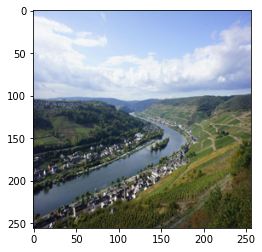

In [18]:
i = 3
plt.imshow(real_images[i].permute(1,2,0).cpu())

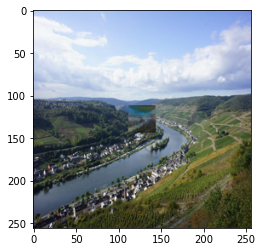

In [19]:
plt.imshow(masked_images[i].permute(1,2,0).cpu().detach().numpy())

In [20]:
lr = 5e-6
beta1 = 0.5
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


criterion = nn.BCELoss()
reconstruction_loss = nn.MSELoss()
num_epochs = 20
best_generator_loss = 10


train_loss = {}
val_loss = {}

for epoch in range(num_epochs):
    generator.train()
    dlosses = []
    glosses = []
    glosses1 = []
    glosses2 = []
    for batch_idx, (real_images, masked_images) in enumerate(train_dataloader):
        
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)

        # Train discriminator
        discriminator.zero_grad()
        generator.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Real images
        real_outputs = discriminator(real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]).reshape(batch_size,1)
        d_loss_real = criterion(real_outputs, real_labels)

        # Fake images
        fake_images = generator(masked_images)
        fake_outputs = discriminator(fake_images.detach()).reshape(batch_size,1)
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train generator
        fake_outputs = discriminator(fake_images).reshape(batch_size,1)
        g_loss1 = criterion(fake_outputs, real_labels)
        g_loss2 = reconstruction_loss(fake_images,real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2])
        g_loss = g_loss1 + 40*g_loss2
        g_loss.backward()
        optimizer_g.step()
        
        dlosses.append(d_loss.item())
        glosses.append(g_loss.item())
        
        glosses1.append(g_loss1.item())
        glosses2.append(g_loss2.item())

        if (batch_idx + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
                  f"Discriminator Loss: {np.mean(dlosses):.4f}, Generator Loss: {np.mean(glosses).item():.4f},{np.mean(glosses1).item():.4f},{np.mean(glosses2).item():.4f}")
            train_loss[(epoch+1),(batch_idx+1)] = (np.mean(glosses1),np.mean(glosses2))
            
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
        f"Discriminator Loss: {np.mean(dlosses):.4f}, Generator Loss: {np.mean(glosses).item():.4f}")
    
    train_loss[(epoch+1),(batch_idx+1)] = (np.mean(glosses1),np.mean(glosses2))
    
    generator.eval()
    val_glosses = []
    for batch_idx, (real_images, masked_images) in enumerate(val_dataloader):
        real_images = real_images.to(device)
        masked_images = masked_images.to(device)
        batch_size = real_images.size(0)
        
        
        fake_patches = generator(masked_images)
        real_patches = real_images[:,:,128-p//2:128 + p//2,128-p//2:128 + p//2]
        g_loss = reconstruction_loss(fake_patches,real_patches)
        
        val_glosses.append(g_loss.item())
    
    mean_g_loss = np.mean(val_glosses)
    
    val_loss[epoch+1] = np.mean(mean_g_loss)
    
    if(mean_g_loss < best_generator_loss):
        best_generator_loss = mean_g_loss
        best_generator_dict = generator.state_dict()
        print("best")
        
    print(f"Epoch [{epoch+1}/{num_epochs}],"
        f"Val Generator Loss: {mean_g_loss:.4f}")

torch.save(best_generator_dict, 'Results/generator_weights_with_gan_reconstruction_loss.pth')

with open('Results/train_with_gan_reconstruction_loss.pickle', 'wb') as handle:
    pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('Results/val_with_gan_reconstruction_loss.pickle', 'wb') as handle:
    pickle.dump(val_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)



Epoch [1/20], Batch [20/98], Discriminator Loss: 1.3434, Generator Loss: 3.4969,0.7157,0.0695
Epoch [1/20], Batch [40/98], Discriminator Loss: 1.2780, Generator Loss: 3.4371,0.7816,0.0664
Epoch [1/20], Batch [60/98], Discriminator Loss: 1.2266, Generator Loss: 3.4141,0.8311,0.0646
Epoch [1/20], Batch [80/98], Discriminator Loss: 1.1800, Generator Loss: 3.4151,0.8751,0.0635
Epoch [1/20], Batch [98/98], Discriminator Loss: 1.1457, Generator Loss: 3.4364
best
Epoch [1/20],Val Generator Loss: 0.0613
Epoch [2/20], Batch [20/98], Discriminator Loss: 0.9277, Generator Loss: 3.5963,1.1238,0.0618
Epoch [2/20], Batch [40/98], Discriminator Loss: 0.9221, Generator Loss: 3.5672,1.1256,0.0610
Epoch [2/20], Batch [60/98], Discriminator Loss: 0.9162, Generator Loss: 3.5648,1.1304,0.0609
Epoch [2/20], Batch [80/98], Discriminator Loss: 0.9057, Generator Loss: 3.5820,1.1457,0.0609
Epoch [2/20], Batch [98/98], Discriminator Loss: 0.8946, Generator Loss: 3.6060
Epoch [2/20],Val Generator Loss: 0.0633
Epo

Epoch [17/20], Batch [80/98], Discriminator Loss: 0.5643, Generator Loss: 5.1627,1.6161,0.0887
Epoch [17/20], Batch [98/98], Discriminator Loss: 0.5759, Generator Loss: 5.1181
Epoch [17/20],Val Generator Loss: 0.0910
Epoch [18/20], Batch [20/98], Discriminator Loss: 0.5216, Generator Loss: 5.2168,1.6520,0.0891
Epoch [18/20], Batch [40/98], Discriminator Loss: 0.5322, Generator Loss: 5.1634,1.6464,0.0879
Epoch [18/20], Batch [60/98], Discriminator Loss: 0.5378, Generator Loss: 5.2125,1.6537,0.0890
Epoch [18/20], Batch [80/98], Discriminator Loss: 0.5442, Generator Loss: 5.1679,1.6381,0.0882
Epoch [18/20], Batch [98/98], Discriminator Loss: 0.5513, Generator Loss: 5.1725
Epoch [18/20],Val Generator Loss: 0.0939
Epoch [19/20], Batch [20/98], Discriminator Loss: 0.6021, Generator Loss: 5.0791,1.5511,0.0882
Epoch [19/20], Batch [40/98], Discriminator Loss: 0.5916, Generator Loss: 5.0463,1.5623,0.0871
Epoch [19/20], Batch [60/98], Discriminator Loss: 0.5707, Generator Loss: 5.1545,1.6243,0.0

In [21]:
generator.load_state_dict(best_generator_dict)

<All keys matched successfully>

In [22]:
for batch_idx, (real_images, masked_images) in enumerate(test_dataloader):
    break
masked_images = masked_images.to(device)
predict = generator(masked_images)

masked_images[:,:,128-p//2:128 + p//2,128-p//2 : 128 + p//2] = predict

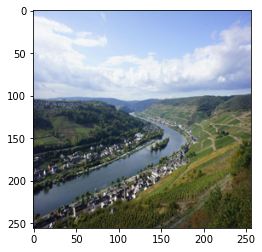

In [23]:
i = 3
plt.imshow(real_images[i].permute(1,2,0).cpu())

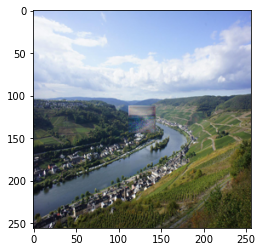

In [24]:
plt.imshow(masked_images[i].permute(1,2,0).cpu().detach().numpy())